### Section 1: Background & Problem Statement

#### Section 1.1: Background

Peer-to-peer (P2P) lending enables individuals to obtain loans directly from other individuals, cutting out the financial institution as the middleman and this sometimes known as "social lending". One of the biggest P2P lending companies is LendingClub in United States where they connect borrowers directly to investors. Borrowers would fill out an application detailing their credit history, loan details, employment status and other self-reported information by which Lending Club would assign a loan grade reflecting the quality of a loan. Potential investors would be able to view the details of various loan applications and make a final decision to invest in the loan.

#### Section 1.2: Problem Statement

The main object of P2P lenders are individual investors who want to get the best risk-reward return for their investment. Our aim for this project is to help P2P lenders decide on the which loans to invest in their portfolio to obtain the best risk-reward (Sharpe Ratio) return. 

### Section 2: Import Libraries and data

In [1]:
# Import the required libraries
import pandas as pd
import numpy as np
import statistics
from itertools import combinations
import re
import seaborn as sns
import matplotlib.pyplot as plt


from sklearn.feature_selection import SelectKBest, f_regression, RFE,f_classif
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score,StratifiedKFold
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix,classification_report, plot_confusion_matrix, plot_roc_curve,recall_score,precision_score,f1_score, precision_recall_fscore_support,  roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from scipy.stats import pearsonr,chi2_contingency
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from imblearn.ensemble import BalancedBaggingClassifier,BalancedRandomForestClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier,GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

import joblib
import pickle


from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GRU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import metrics

from datetime import date
from datetime import time
import datetime as dt


# view data head, there is 81 columns, set option to displace to full rows and columns
pd.set_option("display.max_rows", None, "display.max_columns", None)
import warnings
warnings.filterwarnings('ignore')

In [2]:
#import 2018 data
loans = pd.read_parquet('../accepted_loan_2018v2')

### Section 3: EDA and Data Cleaning

In [3]:
#print loan info
loans.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 197178 entries, 472066 to 967303
Columns: 143 entries, Unnamed: 0 to issue_year
dtypes: datetime64[ns](1), float64(106), int64(2), object(34)
memory usage: 216.6+ MB


In [4]:
#print loan info
loans.describe()

,Unnamed: 0,loan_amnt,funded_amnt,funded_amnt_inv,installment,annual_inc,dti,delinq_2yrs,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,total_acc,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,annual_inc_joint,dti_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,deferral_term,hardship_amount,hardship_length,hardship_dpd,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,issue_year
count,197178.000000,197178.000000,197178.000000,197178.000000,197178.000000,1.971780e+05,196667.000000,197178.000000,197178.000000,197178.000000,197178.000000,87891.000000,28643.000000,197178.000000,197178.000000,1.971780e+05,197178.000000,197178.000000,197178.000000,197178.000000,197178.000000,197178.000000,197178.000000,197178.000000,197178.000000,197178.000000,197178.000000,197178.000000,197178.000000,197178.000000,47671.000000,197178.0,2.596300e+04,25963.000000,197178.000000,1.971780e+05,1.971780e+05,197178.000000,197178.000000,197178.000000,197178.000000,190474.000000,1.971780e+05,165715.000000,197178.00000,197178.000000,1.971780e+05,197128.000000,1.971780e+05,197178.000000,197178.000000,197178.000000,197178.000000,197165.000000,194179.000000,194063.000000,197178.000000,197178.000000,190474.000000,197178.000000,197178.000000,197178.000000,197178.000000,194379.000000,40039.000000,178378.000000,57572.000000,197178.000000,197178.000000,197178.000000,197178.000000,197178.000000,197178.000000,197178.000000,197178.000000,197178.000000,197178.000000,191975.0,197178.000000,197178.000000,197178.000000,197177.000000,194176.000000,197178.000000,197178.000000,1.971780e+05,1.971780e+05,1.971780e+05,1.971780e+05,25963.000000,25963.000000,25963.000000,25963.000000,25963.00000,25963.000000,25527.000000,25963.000000,25963.000000,25963.000000,25963.000000,1460.000000,4299.000000,1460.000000,1460.000000,3982.000000,4299.000000,4299.000000,197178.0
mean,63363.864113,15333.498666,15333.498666,15329.936743,458.399152,7.866595e+04,19.241358,0.230578,706.637049,710.637292,0.505802,37.072806,82.905876,11.429647,0.153841,1.481462e+04,23.368287,5.543404,5.542608,13890.343358,13886.965529,11959.907128,1639.102543,1.845187,289.488389,51.957501,7581.814194,682.525292,662.084512,0.017821,46.229343,1.0,1.257490e+05,19.109866,0.000056,2.599039e+02,1.466684e+05,1.005919,2.686456,0.786416,1.727566,18.844393,3.593724e+04,70.194720,1.33559,2.823373,5.446018e+03,53.459453,3.728697e+04,1.250814,1.641623,2.219436,4.865173,14191.600994,15424.772375,46.916183,0.007673,2.212448,121.181794,170.143550,13.905045,7.857408,1.413510,23.540809,40.731187,6.950919,38.051014,0.493067,3.417141,5.089493,4.771202,7.207914,8.577762,8.102

Text(0.5, 1.0, 'Number of loans breakdown by loan status')

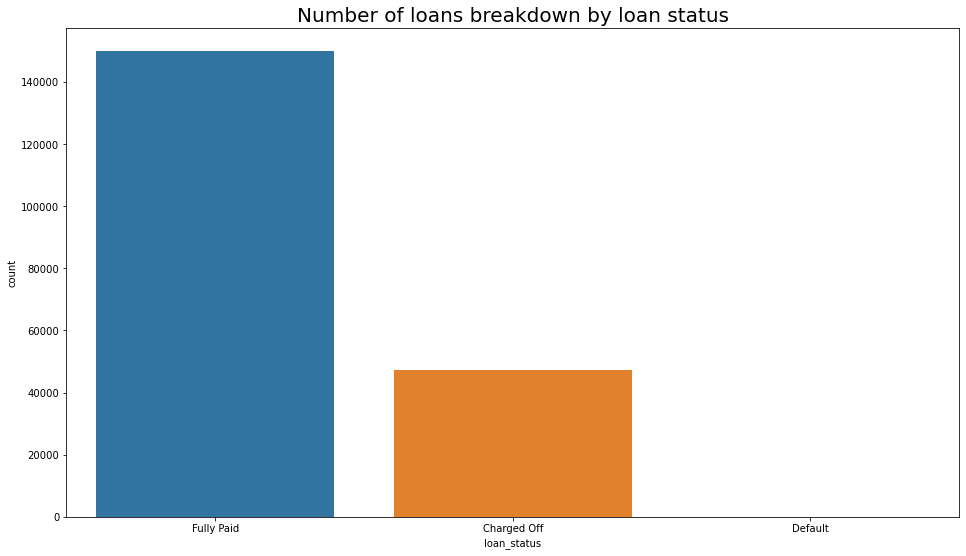

In [5]:
# Establish size of figure.
plt.figure(figsize = (16,9))
           
# Plot the count plot for loan status           
sns.countplot(x='loan_status',data=loans)
plt.title("Number of loans breakdown by loan status",fontsize=20)

In [6]:
# create a new column based on the loan_status column that will be our target variable
loans['status'] = np.where(loans.loc[:, 'loan_status'].isin(['Charged Off', 'Default']), 1, 0)

In [7]:
# change issue date to date time and add issue year feature
loans['issue_d'] =loans['issue_d'].astype('datetime64[ns]')

loans = loans[pd.notnull(loans['issue_d'])]
loans['issue_year'] = loans['issue_d'].dt.year

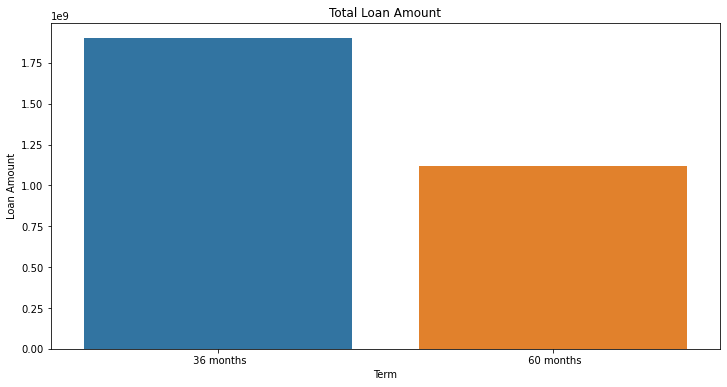

In [8]:
#Plot the amount of loan issued by issue year and term of loan

plt.figure(figsize=(12,6))
sns.barplot(x="term", y="amount", 
            linewidth=2,
             data=pd.DataFrame({'amount' : loans.groupby(['issue_year', 'term']).sum()['loan_amnt']}).reset_index())
plt.xlabel('Term')
plt.ylabel('Loan Amount')
plt.title('Total Loan Amount');

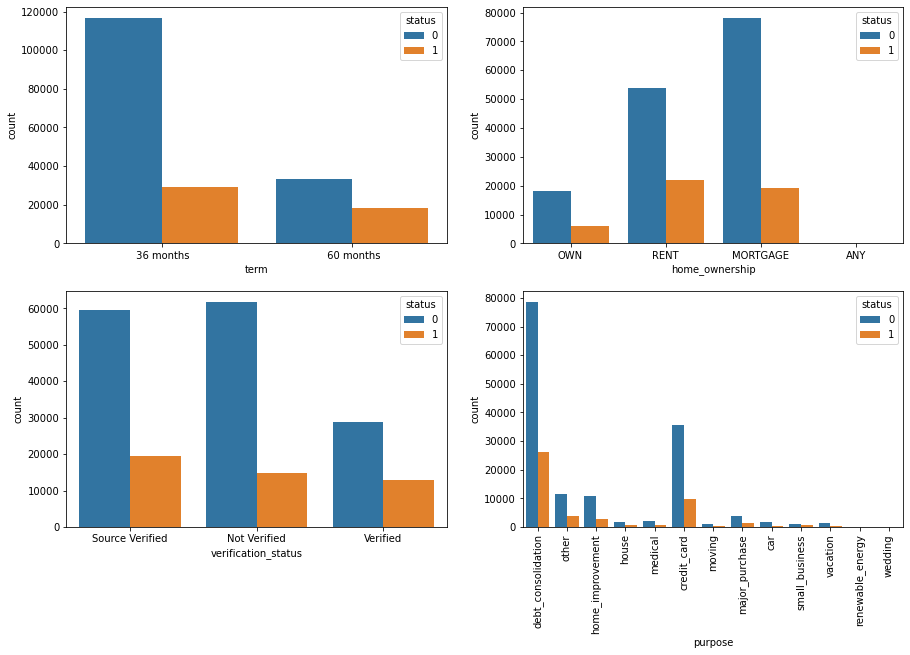

In [9]:
#plot countplot for loan count breakdown by loan status
plt.figure(figsize=(15, 20))

plt.subplot(4, 2, 1)
sns.countplot(x='term', data=loans, hue='status')

plt.subplot(4, 2, 2)
sns.countplot(x='home_ownership', data=loans, hue='status')

plt.subplot(4, 2, 3)
sns.countplot(x='verification_status', data=loans, hue='status')

plt.subplot(4, 2, 4)
g = sns.countplot(x='purpose', data=loans, hue='status')
g.set_xticklabels(g.get_xticklabels(), rotation=90);

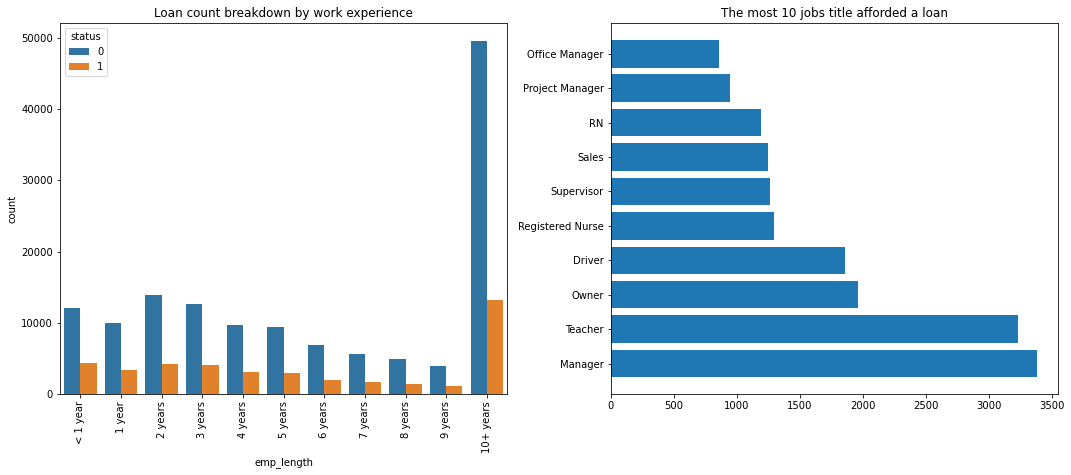

In [10]:
# loan count breakdown by loan status
plt.figure(figsize=(15, 12))

plt.subplot(2, 2, 1)
order = ['< 1 year', '1 year', '2 years', '3 years', '4 years', '5 years', 
          '6 years', '7 years', '8 years', '9 years', '10+ years',]
g = sns.countplot(x='emp_length', data=loans, hue='status', order=order)
plt.title("Loan count breakdown by work experience")
g.set_xticklabels(g.get_xticklabels(), rotation=90);

plt.subplot(2, 2, 2)
plt.barh(loans.emp_title.value_counts()[:10].index, loans.emp_title.value_counts()[:10])
plt.title("The most 10 jobs title afforded a loan")
plt.tight_layout()

Text(0.5, 1.0, 'Total Loan Amount breakdown by status')

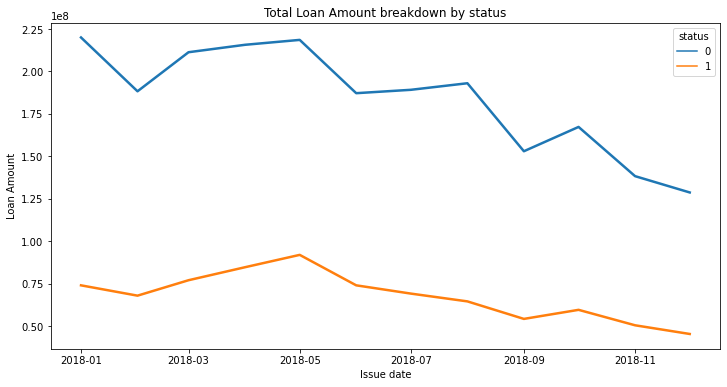

In [11]:
# plot loan amount time series
yamnt = pd.DataFrame({'amount' : loans.groupby(['issue_d', 'status']).sum()['loan_amnt']}).reset_index()

plt.figure(figsize=(12,6))
sns.lineplot(x="issue_d", y="amount",
             hue="status",  
            linewidth=2.5,
             data=yamnt)
plt.xlabel('Issue date')
plt.ylabel('Loan Amount')
plt.title('Total Loan Amount breakdown by status')

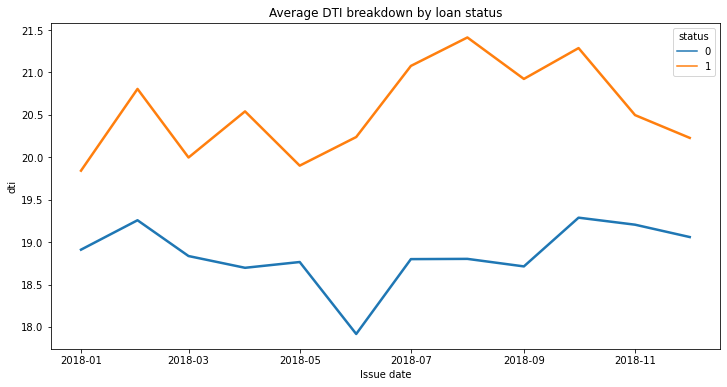

In [12]:
# plot DTI time series breakdown by loan status
yamnt = pd.DataFrame({'dti' : loans.groupby(['issue_d', 'status']).mean()['dti']}).reset_index()

plt.figure(figsize=(12,6))
sns.lineplot(x="issue_d", y="dti",
             hue="status",  
            linewidth=2.5,
             data=yamnt)
plt.xlabel('Issue date')
plt.ylabel('dti')
plt.title('Average DTI breakdown by loan status');

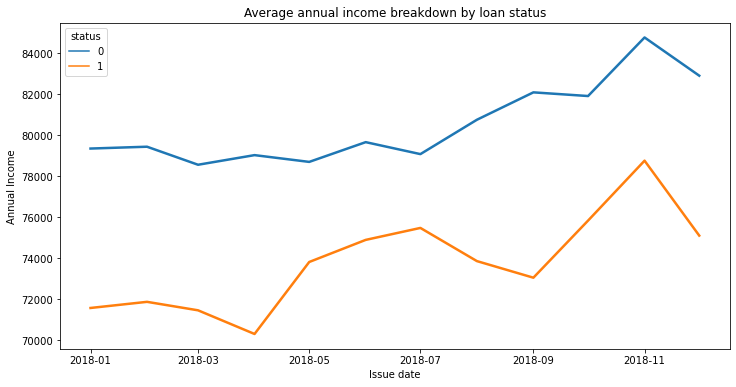

In [13]:
# plot loan amount time series
yamnt = pd.DataFrame({'income' : loans.groupby(['issue_d', 'status']).mean()['annual_inc']}).reset_index()

plt.figure(figsize=(12,6))
sns.lineplot(x="issue_d", y="income",
             hue="status",  
            linewidth=2.5,
             data=yamnt)
plt.xlabel('Issue date')
plt.ylabel('Annual Income')
plt.title('Average annual income breakdown by loan status');

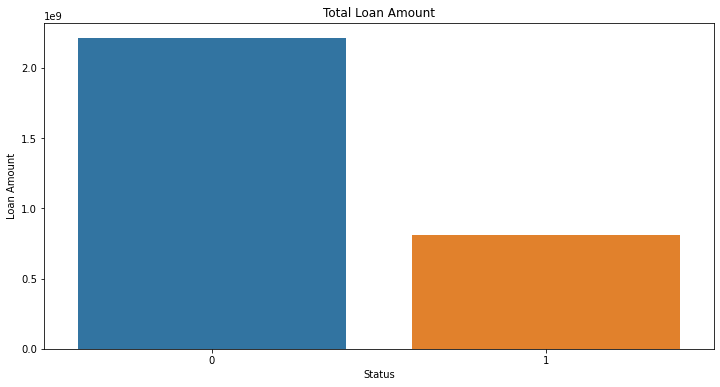

In [14]:
#Plot the amount of loan issued by issue year broken down by loan status

plt.figure(figsize=(12,6))
sns.barplot(x="status", y="amount",
            linewidth=2,
             data=pd.DataFrame({'amount' : loans.groupby(['issue_year', 'status']).sum()['loan_amnt']}).reset_index())
plt.xlabel('Status')
plt.ylabel('Loan Amount')
plt.title('Total Loan Amount');

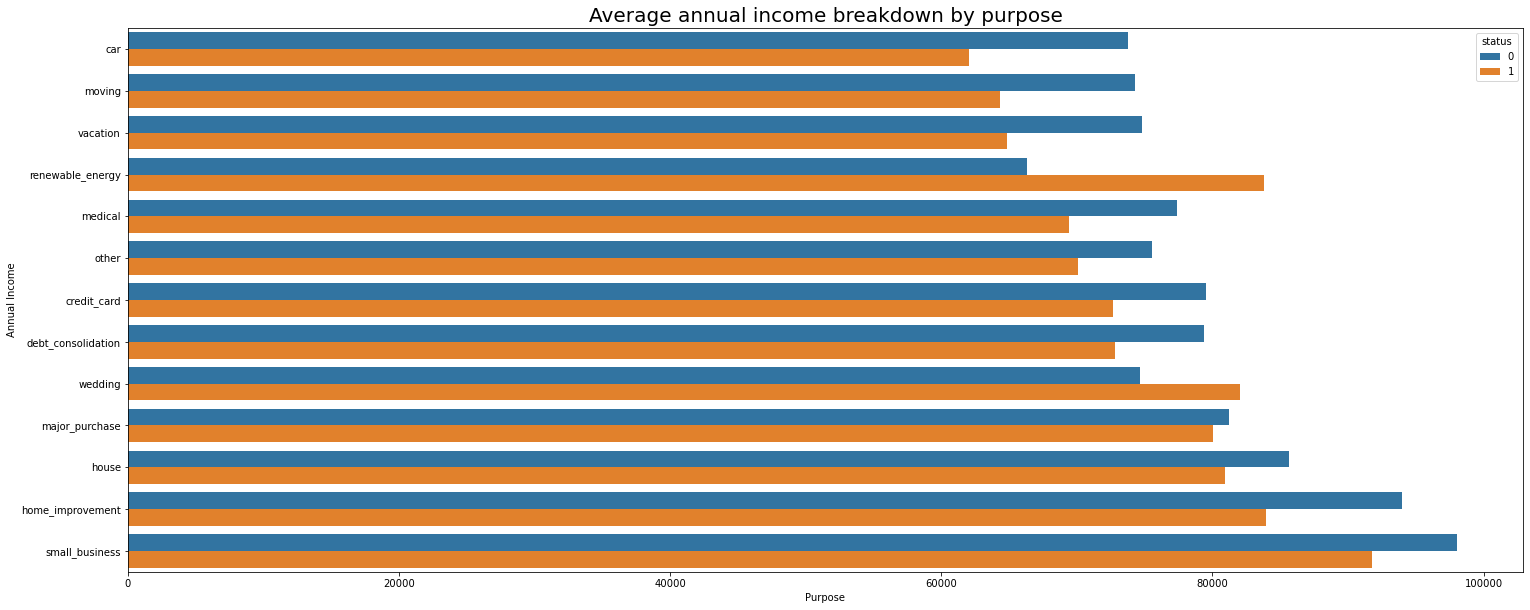

In [15]:
#Plot the amount of loan issued by purpose and loan status


plt.figure(figsize=(25,10))
sns.barplot(x="income", y="purpose",
             hue="status",  
            linewidth=2,
             data=pd.DataFrame({'income' : loans.groupby(['purpose', 'status']).mean()['annual_inc']}).sort_values(by='income').reset_index())
plt.xlabel('Purpose')
plt.ylabel('Annual Income')
plt.title('Average annual income breakdown by purpose',fontsize=20);

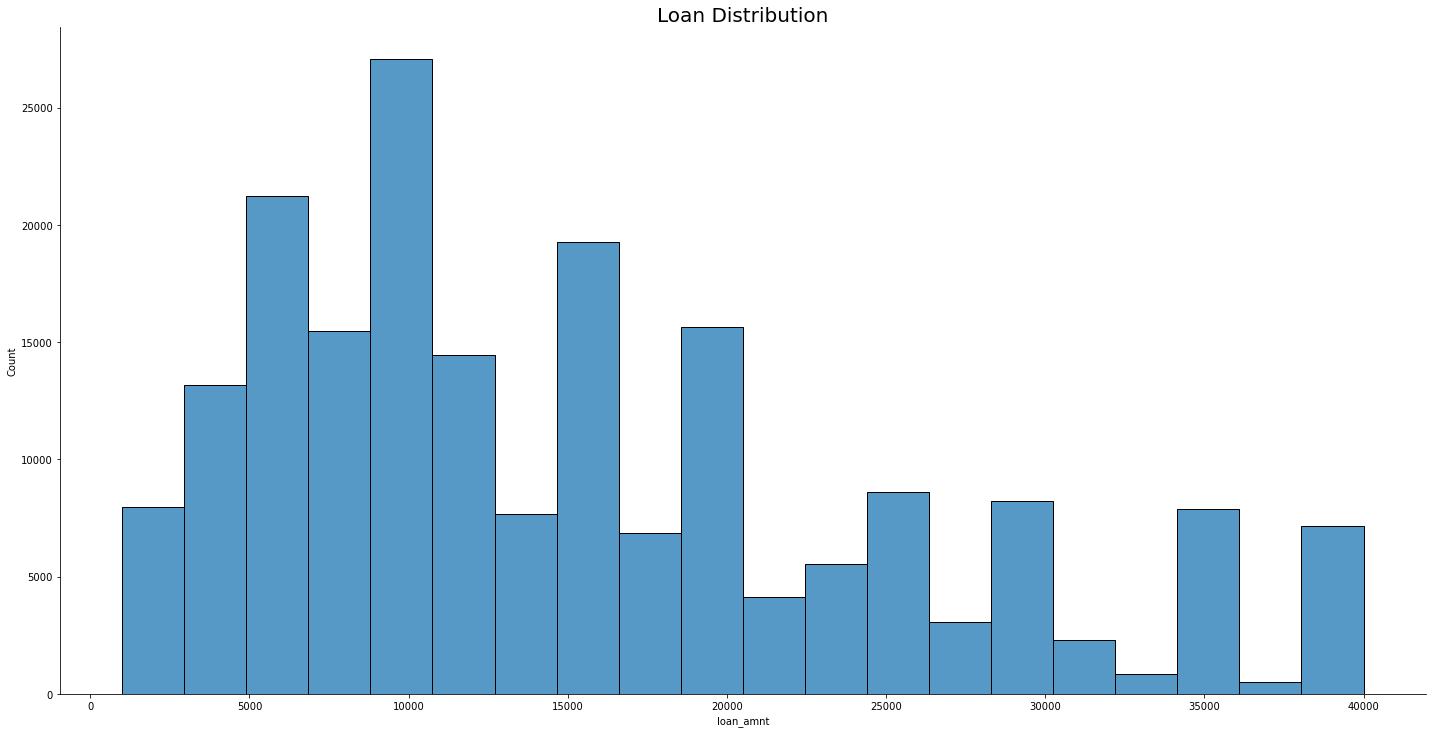

In [16]:
# distribution of loan amount
sns.displot(loans['loan_amnt'],kde=False,bins=20,height=10,aspect=2)
plt.title("Loan Distribution",fontsize=20);


<AxesSubplot:xlabel='installment', ylabel='loan_amnt'>

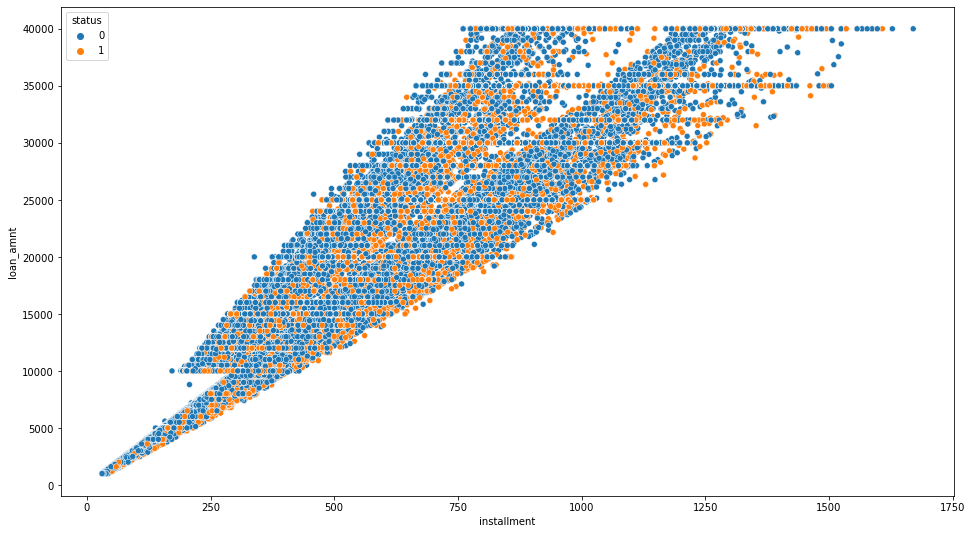

In [17]:
# Plot loan amount vs installment
plt.figure(figsize=(16,9))
sns.scatterplot(x='installment',y='loan_amnt',hue='status',data=loans)


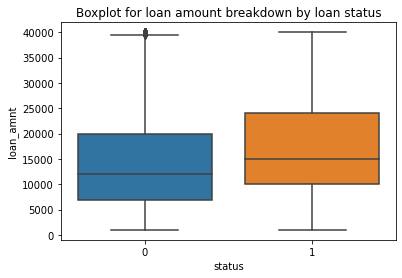

In [18]:
# boxplot for loan amount range for each status of loans
sns.boxplot(x='status',y='loan_amnt',data=loans)
plt.title("Boxplot for loan amount breakdown by loan status",fontsize=12);

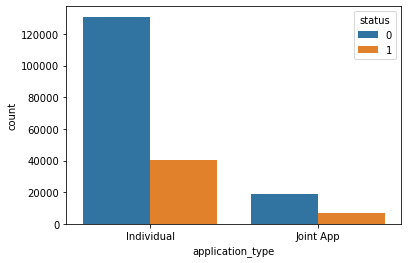

In [19]:
# application type by loan status
sns.countplot(x='application_type',data=loans,hue='status');

<AxesSubplot:xlabel='grade', ylabel='count'>

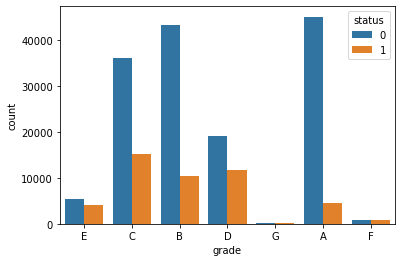

In [20]:
# Loan status by grade
sns.countplot(x='grade',data=loans,hue='status')

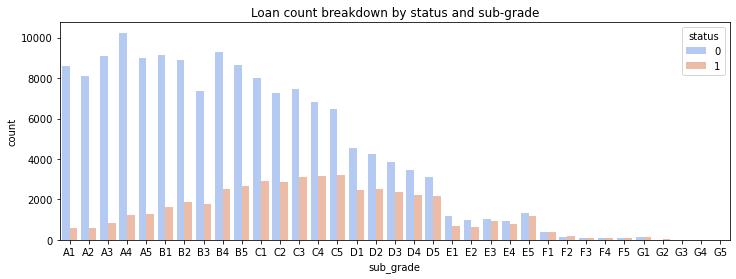

In [21]:
# loan count by subgrade
plt.figure(figsize=(12,4))
subgrade_order = sorted(loans['sub_grade'].unique())
sns.countplot(x='sub_grade',data=loans,order = subgrade_order,palette='coolwarm',hue='status' )
plt.title("Loan count breakdown by status and sub-grade");

#### Section 3.2: Data Cleaning

In [22]:
# Replace those with blank spaces with nan
loans.replace(r'^\s*$', np.nan, regex=True,inplace=True)

In [23]:
# to trim whitespaces
loans = loans.apply(lambda x: x.str.strip() if x.dtype == "object" else x)

In [24]:
# define a function to calculate % of null values

def null_values(df):
    null_percentage = df.isnull().sum()/len(df)*100
    return null_percentage[null_percentage>0].sort_values(ascending=False)

In [25]:
# find the % of null values in descending order
null_percentage = loans.isnull().sum()/len(loans)*100
null_percentage[null_percentage>0].sort_values(ascending=False)

next_pymnt_d                                  99.947256
hardship_loan_status                          99.260059
deferral_term                                 99.259552
hardship_status                               99.259552
hardship_type                                 99.259552
hardship_dpd                                  99.259552
hardship_length                               99.259552
payment_plan_start_date                       99.259552
hardship_end_date                             99.259552
hardship_start_date                           99.259552
hardship_reason                               99.259552
orig_projected_additional_accrued_interest    97.980505
hardship_last_payment_amount                  97.819736
hardship_amount                               97.819736
hardship_payoff_balance_amount                97.819736
verification_status_joint                     87.507734
sec_app_revol_util                            87.053830
sec_app_fico_range_low                        86

In [26]:
# drop features which have more than 70% null values
loans_clean = loans.dropna(thresh = loans.shape[0]*0.3, axis = 1)

In [27]:
# find the % of null values in descending order
null_values(loans_clean)

mths_since_last_delinq    55.425555
il_util                   15.956648
emp_title                 10.249622
mths_since_recent_inq      9.534532
emp_length                 8.543549
mo_sin_old_il_acct         3.399974
mths_since_rcnt_il         3.399974
num_tl_120dpd_2m           2.638733
bc_util                    1.579791
percent_bc_gt_75           1.522482
bc_open_to_buy             1.520961
hardship_flag              1.440323
mths_since_recent_bc       1.419530
last_pymnt_d               0.322551
dti                        0.259157
revol_util                 0.130339
all_util                   0.025358
avg_cur_bal                0.006593
last_credit_pull_d         0.001521
pct_tl_nvr_dlq             0.000507
dtype: float64

In [28]:
# for those with mths_since features, we assume that these are blanks as they do not have any records and the number of months since the "last" record will be input as maximum

mths_since = [
#    'mths_since_recent_revol_delinq',
    'mths_since_last_delinq',
             'mths_since_rcnt_il','mths_since_recent_inq','mo_sin_old_il_acct',
              'mths_since_recent_bc'
            ]

loans_clean[mths_since] = loans_clean[mths_since].fillna(loans_clean[mths_since].max())

In [29]:
# for those with open account for the last X mths features, we assume that these are blanks as they do not have acct open and thus will be set to 0
fill_0 = ['il_util','all_util','total_cu_tl','inq_last_12m','inq_last_12m','open_acc_6m',
          'inq_fi','open_rv_12m','max_bal_bc','open_act_il','open_il_12m','open_il_24m','open_rv_24m',
          'total_bal_il','emp_length','bc_util','percent_bc_gt_75'
            ]

loans_clean[fill_0] = loans_clean[fill_0].fillna(0)

In [30]:
# find the % of null values in descending order
null_values(loans_clean)

emp_title             10.249622
num_tl_120dpd_2m       2.638733
bc_open_to_buy         1.520961
hardship_flag          1.440323
last_pymnt_d           0.322551
dti                    0.259157
revol_util             0.130339
avg_cur_bal            0.006593
last_credit_pull_d     0.001521
pct_tl_nvr_dlq         0.000507
dtype: float64

In [31]:
'''
drop redundant and forward-looking columns
redundant like id, member_id, title, etc.
forward-looking like recoveries, collection_recovery_fee, etc.
drop next_pymnt_d since, given that our data is historical and this column is supposed to have future dates, will not make sense for our model
'''

loans_clean.drop(columns = ['id', 'Unnamed: 0', 'url', 'title', 'zip_code','emp_title',
                          'recoveries', 'collection_recovery_fee', 'total_rec_prncp', 'total_rec_late_fee',
                      'funded_amnt','funded_amnt_inv',
                      'out_prncp','out_prncp_inv','total_pymnt','total_pymnt_inv','total_rec_int',
                       'total_rec_late_fee','total_rec_prncp',
                       'last_pymnt_d', 'last_pymnt_amnt', 
                            'last_credit_pull_d',
           'last_fico_range_high', 'last_fico_range_low','collections_12_mths_ex_med', 'policy_code','acc_now_delinq','avg_cur_bal','bc_open_to_buy',
                            'chargeoff_within_12_mths', 'delinq_amnt','total_bal_ex_mort',
                            'num_tl_120dpd_2m', 'num_tl_30dpd',
           'num_tl_90g_dpd_24m', 'num_tl_op_past_12m','pct_tl_nvr_dlq',
           'debt_settlement_flag',
                    'grade','pymnt_plan'
                      ], inplace = True)

In [32]:
#print current features
print(list(loans_clean.columns))

['loan_amnt', 'term', 'int_rate', 'installment', 'sub_grade', 'emp_length', 'home_ownership', 'annual_inc', 'verification_status', 'issue_d', 'loan_status', 'purpose', 'addr_state', 'dti', 'delinq_2yrs', 'earliest_cr_line', 'fico_range_low', 'fico_range_high', 'inq_last_6mths', 'mths_since_last_delinq', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'initial_list_status', 'application_type', 'tot_coll_amt', 'tot_cur_bal', 'open_acc_6m', 'open_act_il', 'open_il_12m', 'open_il_24m', 'mths_since_rcnt_il', 'total_bal_il', 'il_util', 'open_rv_12m', 'open_rv_24m', 'max_bal_bc', 'all_util', 'total_rev_hi_lim', 'inq_fi', 'total_cu_tl', 'inq_last_12m', 'acc_open_past_24mths', 'bc_util', 'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mort_acc', 'mths_since_recent_bc', 'mths_since_recent_inq', 'num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_actv_rev_tl', 'num_bc_sats', 'num_bc_tl', 'num_il_tl', 'num_op_rev_tl', 'num_rev_accts', 'num_rev_t

In [33]:
# create a function to create date
def create_date(date):
    return dt.datetime.strptime(date[-4:]+date[:3]+'01', '%Y%b%d')

In [34]:
# convert to datetime using the created date function
loans_clean.earliest_cr_line = loans_clean.earliest_cr_line.apply(create_date)

In [35]:
# create the length of credit line based on earliest creat date
loans_clean['cr_year'] = loans_clean.earliest_cr_line.apply(lambda x: x.year)
loans_clean['cr_length'] = loans_clean['issue_year'] - loans_clean['cr_year']

In [36]:
#  Extract only numbers for columns term, int_rate,emp_length, revol_util

ext_num = ['term','int_rate','emp_length','revol_util']

for col in ext_num:
    loans_clean[col] = loans_clean[col].str.extract('([0-9]+[.]*[0-9]*)').apply(pd.to_numeric,errors='coerce')

In [37]:
# encode sub grade
sub_grade = ['A1','A2','A3','A4','A5','B1','B2','B3','B4','B5','C1','C2','C3','C4','C5','D1','D2','D3','D4','D5','E1','E2','E3','E4','E5','F1','F2','F3','F4','F5','G1','G2','G3','G4','G5']
grade_value = range(1,len(sub_grade)+1)
grade_dict = dict(zip(sub_grade, grade_value))

In [38]:
loans_clean['sub_grade_num'] = loans_clean['sub_grade'].map(grade_dict)

In [39]:
loans_clean['hardship_flag'].value_counts()

N    193835
Y       503
Name: hardship_flag, dtype: int64

In [40]:
# encode hardship 
hardship_dict = {'N': 0,'Y': 1}
loans_clean['hardship_flag'] = loans_clean['hardship_flag'].map(hardship_dict)

In [41]:
# find the % of null values in descending order
null_values(loans_clean)

emp_length       8.543549
hardship_flag    1.440323
dti              0.259157
revol_util       0.130339
dtype: float64

In [42]:
# As the rest of the null values % is small, dropped the rows which have null values
loans_clean = loans_clean.dropna(axis=0).reset_index(drop=True)

In [43]:
# find  correlated variables to consider for feature engineering
abs(loans_clean.corr()['status']).sort_values(ascending=False)

status                        1.000000
sub_grade_num                 0.271241
int_rate                      0.266449
term                          0.161271
fico_range_low                0.141846
fico_range_high               0.141844
loan_amnt                     0.113820
installment                   0.111482
mort_acc                      0.103897
tot_hi_cred_lim               0.095575
tot_cur_bal                   0.084787
bc_util                       0.077591
revol_util                    0.075947
inq_last_6mths                0.075314
total_bc_limit                0.074474
mo_sin_old_rev_tl_op          0.074018
num_actv_rev_tl               0.073777
open_rv_24m                   0.072904
num_rev_tl_bal_gt_0           0.070931
total_rev_hi_lim              0.068327
all_util                      0.068061
percent_bc_gt_75              0.067256
open_rv_12m                   0.063733
inq_last_12m                  0.061319
num_actv_bc_tl                0.060939
cr_length                

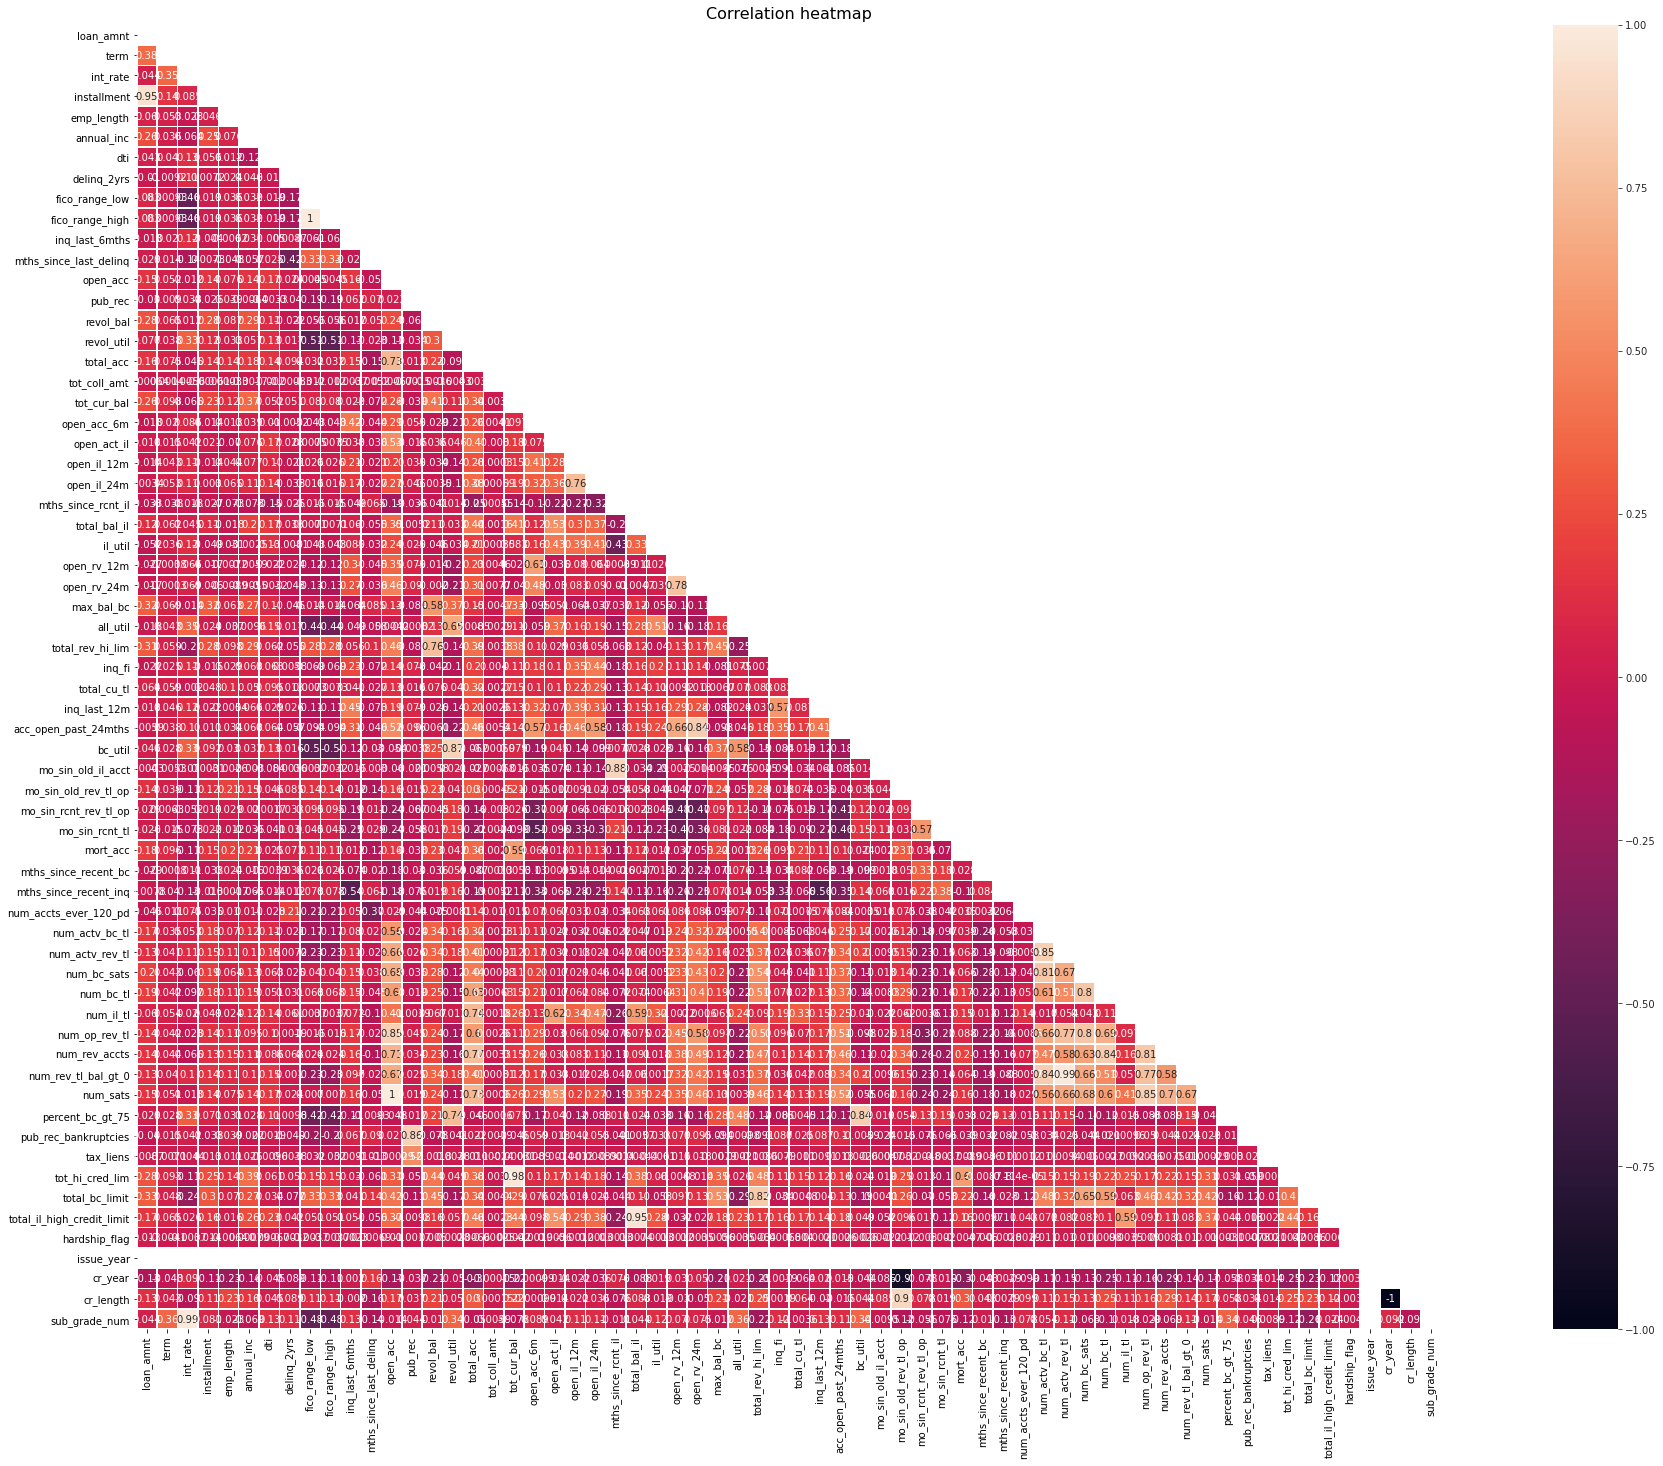

In [44]:
# look for Multicollinearity
# Establish size of figure.
plt.figure(figsize = (40,24))

# Set title for the figure.
plt.title('Correlation heatmap',size=16)

# Get correlation of variables
corr = loans_clean.drop(columns=['status']).corr()

# Set up mask to be "True" in the upper triangle.
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

# Plot our correlation heatmap, while masking the upper triangle to be white.

with sns.axes_style("white"):
    sns.heatmap(corr, mask = mask, square = True, annot = True, vmin = -1, vmax = 1, linewidths = 0.5)

## Section 4: Feature Engineering/Feature Selection

In [45]:
y= loans_clean['status']
X= loans_clean.drop(columns=['status','loan_status','issue_d','issue_year','earliest_cr_line','cr_year','sub_grade'])

In [46]:
# since fico low and high is highly corelated we take the mean instead
X['fico_avg'] = X[['fico_range_low', 'fico_range_high']].mean(axis=1)

In [47]:
# create additional features
X['term_amnt'] = X['loan_amnt']*X['term'] 
X['int_amnt'] = X['int_rate']/100*X['loan_amnt']*X['term']/12
X['int_income'] = X['int_amnt']/[x if x>0.0 else 1.0  for x in X['annual_inc']]

In [48]:
# drop features which has high Multicollinearity

X.drop(columns=['fico_range_low','fico_range_high'],axis=1,inplace=True)

In [49]:
# Features info 
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 177604 entries, 0 to 177603
Data columns (total 70 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   loan_amnt                   177604 non-null  float64
 1   term                        177604 non-null  int64  
 2   int_rate                    177604 non-null  float64
 3   installment                 177604 non-null  float64
 4   emp_length                  177604 non-null  float64
 5   home_ownership              177604 non-null  object 
 6   annual_inc                  177604 non-null  float64
 7   verification_status         177604 non-null  object 
 8   purpose                     177604 non-null  object 
 9   addr_state                  177604 non-null  object 
 10  dti                         177604 non-null  float64
 11  delinq_2yrs                 177604 non-null  float64
 12  inq_last_6mths              177604 non-null  float64
 13  mths_since_las

In [51]:
# create dummies for categorial features
X = pd.get_dummies(X)

In [53]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 177604 entries, 0 to 177603
Columns: 138 entries, loan_amnt to application_type_Joint App
dtypes: float64(61), int64(3), uint8(74)
memory usage: 99.3 MB


In [54]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=7, test_size=0.3,stratify=y)

In [55]:
# Scaling using standardscaler
ss = StandardScaler()
X_scaled_train = ss.fit_transform(X_train)
X_scaled_test = ss.transform(X_test)

In [56]:
#save scaler 
joblib.dump(ss,'scaler.pkl')

['scaler.pkl']

In [57]:
# Use PCA to reduce the dimensions to speed up the ML algo without sacrificing much of the explanability. In this case, we want to have 90% of the explanability retained
pca_model = PCA(0.9)

In [58]:
pca_model.fit(X_scaled_train)

PCA(n_components=0.9)

In [59]:
# to check to make sure that the explained variance is 90%
np.sum(pca_model.explained_variance_ratio_)

0.9005671223578819

In [60]:
# Number of features after PCA
pca_model.n_components_ 

87

In [61]:
# transform the features using PCA
X_scaled_train_PCA = pca_model.transform(X_scaled_train)
X_scaled_test_PCA = pca_model.transform(X_scaled_test)

In [62]:
#save PCA model
joblib.dump(pca_model,'pca_model.pkl')

['pca_model.pkl']

## Section 5: Modelling

#### Section 5.1: Logistic Regression

In [63]:
# Gridsearch for hyperparameter tuning

lr = LogisticRegression(class_weight='balanced',max_iter=10000)

lr_params = {
    'C': np.linspace(0.5,1,2),
    'solver': ['lbfgs','newton-cg']
}

gs_lr = GridSearchCV(lr, param_grid = lr_params, cv=5,
                     scoring='roc_auc',n_jobs=-1,
             )

# Fit GridSearch to training data.
gs_lr.fit(X_scaled_train_PCA, y_train)

GridSearchCV(cv=5,
             estimator=LogisticRegression(class_weight='balanced',
                                          max_iter=10000),
             n_jobs=-1,
             param_grid={'C': array([0.5, 1. ]),
                         'solver': ['lbfgs', 'newton-cg']},
             scoring='roc_auc')

In [64]:
# find best parameters for logistic regression from the hyper parameter tuning
gs_lr.best_params_

{'C': 0.5, 'solver': 'newton-cg'}

In [65]:
# Instantiate and fit logistic regression based on best parameters
lr = LogisticRegression(solver='newton-cg', C=0.5,max_iter=10000,n_jobs=-1,random_state=42,class_weight='balanced')
lr.fit(X_scaled_train_PCA, y_train)

LogisticRegression(C=0.5, class_weight='balanced', max_iter=10000, n_jobs=-1,
                   random_state=42, solver='newton-cg')

In [66]:
# create function to plot classification report and confusion matrix
def matrix(model,X,y):
    preds = model.predict(X)
    print('Classification Report')
    print(classification_report(y,preds))
    print('Confusion Matrix')
    print(plot_confusion_matrix(model,X,y));

Classification Report
              precision    recall  f1-score   support

           0       0.87      0.67      0.76     41019
           1       0.38      0.66      0.48     12263

    accuracy                           0.67     53282
   macro avg       0.62      0.67      0.62     53282
weighted avg       0.76      0.67      0.69     53282

Confusion Matrix


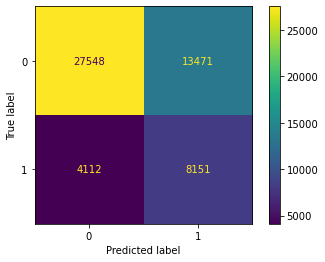

In [67]:
#plot matrix using function
matrix(lr,X_scaled_test_PCA,y_test)

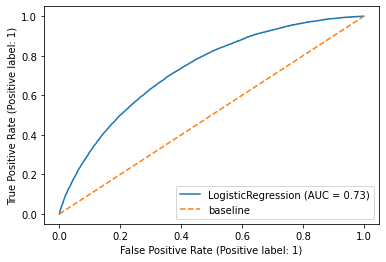

In [68]:
# plot ROC curve which shows that is better than baseline (random classifier)
plot_roc_curve(lr, X_scaled_test_PCA, y_test)
plt.plot([0, 1], [0, 1],
         label='baseline', linestyle='--')
plt.legend();

#### Section 5.2: Random Forest

#### Section 5.2: LGBMClassifier

In [69]:
# Gridsearch for hyperparameter tuning

lgb = LGBMClassifier(class_weight='balanced',random_state=42)
lgb_params = {
        'n_estimators': [100,80], 
        'learning_rate': [0.1,0.05],
        'max_depth' : [2,3],
        'num_leaves' : [10,20,30],
      'reg_alpha': [10,15],
        'min_data_in_leaf' : [800,1000]
    }

# Instantiate 5-fold GridSearchCV.
gs_lgb = GridSearchCV(lgb, param_grid = lgb_params, cv=5,
                     scoring='roc_auc',n_jobs=-1,
             )

# Fit GridSearch to training data.
gs_lgb.fit(X_scaled_train_PCA, y_train)

[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800


GridSearchCV(cv=5,
             estimator=LGBMClassifier(class_weight='balanced', random_state=42),
             n_jobs=-1,
             param_grid={'learning_rate': [0.1, 0.05], 'max_depth': [2, 3],
                         'min_data_in_leaf': [800, 1000],
                         'n_estimators': [100, 80], 'num_leaves': [10, 20, 30],
                         'reg_alpha': [10, 15]},
             scoring='roc_auc')

In [70]:
# Find the best hyperparameters
gs_lgb.best_params_

{'learning_rate': 0.1,
 'max_depth': 3,
 'min_data_in_leaf': 800,
 'n_estimators': 100,
 'num_leaves': 10,
 'reg_alpha': 15}

In [71]:
# Instantiate and fit with the best hyperparameters

lgb = LGBMClassifier(class_weight='balanced',learning_rate= 0.1, max_depth= 3,min_data_in_leaf= 800, n_estimators= 100, num_leaves=10,reg_alpha= 15,random_state=42,n_jobs=-1)
lgb.fit(X_scaled_train_PCA, y_train)

LGBMClassifier(class_weight='balanced', max_depth=3, min_data_in_leaf=800,
               num_leaves=10, random_state=42, reg_alpha=15)

Classification Report
              precision    recall  f1-score   support

           0       0.87      0.65      0.74     41019
           1       0.37      0.69      0.48     12263

    accuracy                           0.66     53282
   macro avg       0.62      0.67      0.61     53282
weighted avg       0.76      0.66      0.68     53282

Confusion Matrix


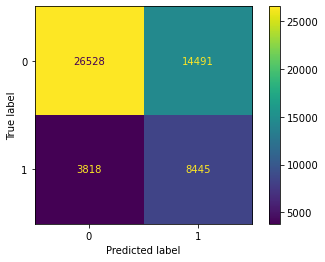

In [72]:
#plot matrix using function
matrix(lgb,X_scaled_test_PCA,y_test)

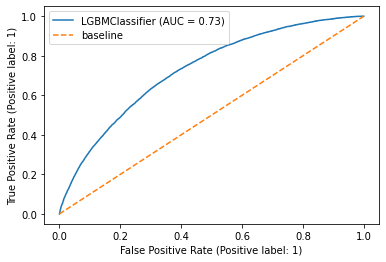

In [73]:
# plot ROC curve which shows that is better than baseline (random classifier)
plot_roc_curve(lgb, X_scaled_test_PCA, y_test)
plt.plot([0, 1], [0, 1],
         label='baseline', linestyle='--')
plt.legend();

#### Section 5.3: CatBoostClassifier

In [74]:
# Gridsearch for hyperparameter tuning

cbc = CatBoostClassifier(auto_class_weights='Balanced',random_state=42)
cbc_params = {'depth': [2,4],
          'learning_rate' : [ 0.1, 0.01],
         'l2_leaf_reg': [10,14],
         'iterations': [150]
    }

# Instantiate 5-fold GridSearchCV.
gs_cbc = GridSearchCV(cbc, param_grid = cbc_params, cv=5,
                     scoring='roc_auc',n_jobs=-1,
             )

# Fit GridSearch to training data.
gs_cbc.fit(X_scaled_train_PCA, y_train)

0:	learn: 0.6833086	total: 159ms	remaining: 23.7s
1:	learn: 0.6739658	total: 176ms	remaining: 13s
2:	learn: 0.6661125	total: 191ms	remaining: 9.36s
3:	learn: 0.6599945	total: 208ms	remaining: 7.59s
4:	learn: 0.6543547	total: 223ms	remaining: 6.46s
5:	learn: 0.6497734	total: 238ms	remaining: 5.72s
6:	learn: 0.6461355	total: 254ms	remaining: 5.18s
7:	learn: 0.6429376	total: 269ms	remaining: 4.78s
8:	learn: 0.6400142	total: 284ms	remaining: 4.46s
9:	learn: 0.6379894	total: 300ms	remaining: 4.21s
10:	learn: 0.6358380	total: 316ms	remaining: 3.99s
11:	learn: 0.6336751	total: 332ms	remaining: 3.81s
12:	learn: 0.6320829	total: 347ms	remaining: 3.65s
13:	learn: 0.6306267	total: 362ms	remaining: 3.52s
14:	learn: 0.6295814	total: 382ms	remaining: 3.44s
15:	learn: 0.6284665	total: 398ms	remaining: 3.33s
16:	learn: 0.6276451	total: 415ms	remaining: 3.25s
17:	learn: 0.6268020	total: 432ms	remaining: 3.17s
18:	learn: 0.6257604	total: 449ms	remaining: 3.09s
19:	learn: 0.6251480	total: 464ms	remaining

GridSearchCV(cv=5,
             estimator=<catboost.core.CatBoostClassifier object at 0x00000153A19C0A30>,
             n_jobs=-1,
             param_grid={'depth': [2, 4], 'iterations': [150],
                         'l2_leaf_reg': [10, 14],
                         'learning_rate': [0.1, 0.01]},
             scoring='roc_auc')

In [75]:
gs_cbc.best_params_

{'depth': 4, 'iterations': 150, 'l2_leaf_reg': 14, 'learning_rate': 0.1}

In [76]:
cbc = CatBoostClassifier(auto_class_weights='Balanced',depth= 4, iterations= 150, l2_leaf_reg = 14, learning_rate= 0.1,random_state=42)
cbc.fit(X_scaled_train_PCA, y_train)

0:	learn: 0.6833086	total: 59.7ms	remaining: 8.9s
1:	learn: 0.6739658	total: 77.4ms	remaining: 5.73s
2:	learn: 0.6661125	total: 94.6ms	remaining: 4.64s
3:	learn: 0.6599945	total: 112ms	remaining: 4.09s
4:	learn: 0.6543547	total: 128ms	remaining: 3.71s
5:	learn: 0.6497734	total: 145ms	remaining: 3.49s
6:	learn: 0.6461355	total: 162ms	remaining: 3.31s
7:	learn: 0.6429376	total: 179ms	remaining: 3.19s
8:	learn: 0.6400142	total: 196ms	remaining: 3.07s
9:	learn: 0.6379894	total: 213ms	remaining: 2.99s
10:	learn: 0.6358380	total: 231ms	remaining: 2.92s
11:	learn: 0.6336751	total: 246ms	remaining: 2.83s
12:	learn: 0.6320829	total: 264ms	remaining: 2.78s
13:	learn: 0.6306267	total: 280ms	remaining: 2.72s
14:	learn: 0.6295814	total: 299ms	remaining: 2.69s
15:	learn: 0.6284665	total: 316ms	remaining: 2.65s
16:	learn: 0.6276451	total: 333ms	remaining: 2.6s
17:	learn: 0.6268020	total: 351ms	remaining: 2.57s
18:	learn: 0.6257604	total: 369ms	remaining: 2.54s
19:	learn: 0.6251480	total: 384ms	remain

Classification Report
              precision    recall  f1-score   support

           0       0.87      0.65      0.75     41019
           1       0.37      0.69      0.48     12263

    accuracy                           0.66     53282
   macro avg       0.62      0.67      0.61     53282
weighted avg       0.76      0.66      0.68     53282

Confusion Matrix


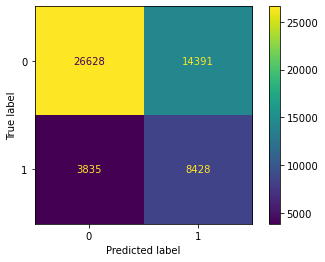

In [77]:
#plot matrix using function
matrix(cbc,X_scaled_test_PCA,y_test)

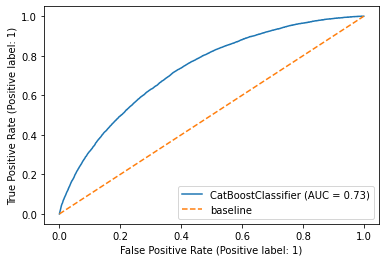

In [78]:
# plot ROC curve which shows that is better than baseline (random classifier)
plot_roc_curve(cbc, X_scaled_test_PCA, y_test)
plt.plot([0, 1], [0, 1],
         label='baseline', linestyle='--')
plt.legend();

#### Section 5.4:  Model Evaluation

In [79]:
# function to evaluate model
def evaluate_model(model_name,model,X_train,y_train,X_test,y_test):
    train_auc = roc_auc_score(y_train, model.predict_proba(X_train)[:, 1])
    preds = model.predict(X_test)
    test_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
    train_precision, train_recall, train_fscore, train_support = precision_recall_fscore_support(y_train, model.predict(X_train),average='binary')
    test_precision, test_recall, test_fscore, test_support = precision_recall_fscore_support(y_test, preds,average='binary')
    auc_variance = abs((train_auc/test_auc)-1)
    summary1 = {
                'Model_name' : model_name,
                'train_auc': round(train_auc,3),
                'test_auc': round(test_auc,3),
                'auc_variance' :round(auc_variance,3),
                'train_precision': round(train_precision,3),
                'test_precision': round(test_precision,3),
                'train_recall': round(train_recall,3),
                'test_recall' : round(test_recall,3)
                   }
    summary= pd.DataFrame([summary1])
    return summary

In [80]:
#evaluate model
pd.concat([evaluate_model('Logistic regression',lr,X_scaled_train_PCA,y_train,X_scaled_test_PCA,y_test),
        evaluate_model('CatBoostClassifier',cbc,X_scaled_train_PCA,y_train,X_scaled_test_PCA,y_test),
         evaluate_model('Light GBM',lgb,X_scaled_train_PCA,y_train,X_scaled_test_PCA,y_test)]
          ,axis=0).reset_index(drop=True)

,Model_name,train_auc,test_auc,auc_variance,train_precision,test_precision,train_recall,test_recall
0,Logistic regression,0.729,0.731,0.004,0.377,0.377,0.663,0.665
1,CatBoostClassifier,0.735,0.731,0.005,0.373,0.369,0.693,0.687
2,Light GBM,0.735,0.729,0.008,0.371,0.368,0.694,0.689


**Note**: Based on the model evaluation above, the train and test AUC are very similiar and all 3 models generalised quite well (no overfitting) based on the auc variance between the train and test data. 
However, we selected Light GBM Classifier as it is the fastest and has the best recall score (TP/(TP+FN)). We want the best recall score as we aimed to reduce the number of false negative (ie actual defaulted loan but predict as non-default) due to the high cost of false negative (investing in defaulted loan) which will affect our risk adjusted return (sharpe ratio). 

In [81]:
#save final model
joblib.dump(lgb,'final_model.pkl')

['final_model.pkl']

### Section 6: Fit the best model

In [82]:
# load the best model
model = joblib.load('final_model.pkl')

In [83]:
# use the best model to predict default
y_preds = model.predict(X_scaled_test_PCA)
#y_proba = model.predict_proba(X_scaled_test_PCA)[:, 1]

In [84]:
# convert into dataframe
df_pred = pd.DataFrame((y_preds),columns=['default'])
results = pd.concat([X_test.reset_index(drop=True),df_pred],axis=1)

In [85]:
# extract the actual loan status for ROI and sharpe ratio for evaluation later
y_actual = pd.DataFrame(y_test,columns=['status']).reset_index(drop=True)

In [86]:
# combined the predicted and actual loan status
results = pd.concat([results,y_actual],axis=1)

In [87]:
# Create a new dataframe that contain only non-default loan predicted by the model
results_clean = results[results['default']==0]

### Section 7: Conclusion and Recommendation

In [94]:
# function to calculate ROI and sharpe ratio

def portfolio_return(df,x):
    annual_return =[]
    rf_rate=1.5 #  risk free rate based on current US 10 treasury bond yield
    for num in range(1000):  # we randomly select 1000 times to create the portfolio loan return distribution
    
        df2 = df.sample(n=x, replace=False) # to randomly sample the number of loans to invest
    
        total_interest = df2[df2['status']==0]['int_amnt'].sum()  # total interest received from non default loan 
        total_defaulted_loan = df2[df2['status']==1]['loan_amnt'].sum()  # total default amount in the portfolio
        df2['term_amnt'] = df2['loan_amnt']*df2['term']   
        weighted_term_yr = (df2['term_amnt'].sum() / df2['loan_amnt'].sum())/12  # using the term amount the calcuate the average term 
        annualised_return = ((((total_interest-total_defaulted_loan)/df2['loan_amnt'].sum())/weighted_term_yr))*100 # calculate average return 
        annual_return.append(annualised_return)
    
    avg_return = round(statistics.mean(annual_return),2)
    std_return = round(statistics.stdev(annual_return),2)
    sharpe_ratio = round((avg_return-rf_rate)/std_return,2) # sharpe ratio is the risk adjusted return, the higher the better it is
    plt.figure(figsize=(25,10))
    plt.rcParams['font.size'] = '20'
    sns.distplot(annual_return)
    plt.title('Portfolio annual return distribution',fontsize=20);
    print(f'Average return for portfolio: {avg_return}\nStandard Deviation: {std_return} \nSharpe Ratio: {sharpe_ratio}')
    return [avg_return,std_return,sharpe_ratio]

**Note**: The assumption for defaulted loan:
1. 0 recovery rate. The full loan amount is defaulted
2. No interest earned from defaulted loan as  we removed any forward looking features from the data.

Average return for portfolio: 2.3
Standard Deviation: 0.19 
Sharpe Ratio: 4.21


[2.3, 0.19, 4.21]

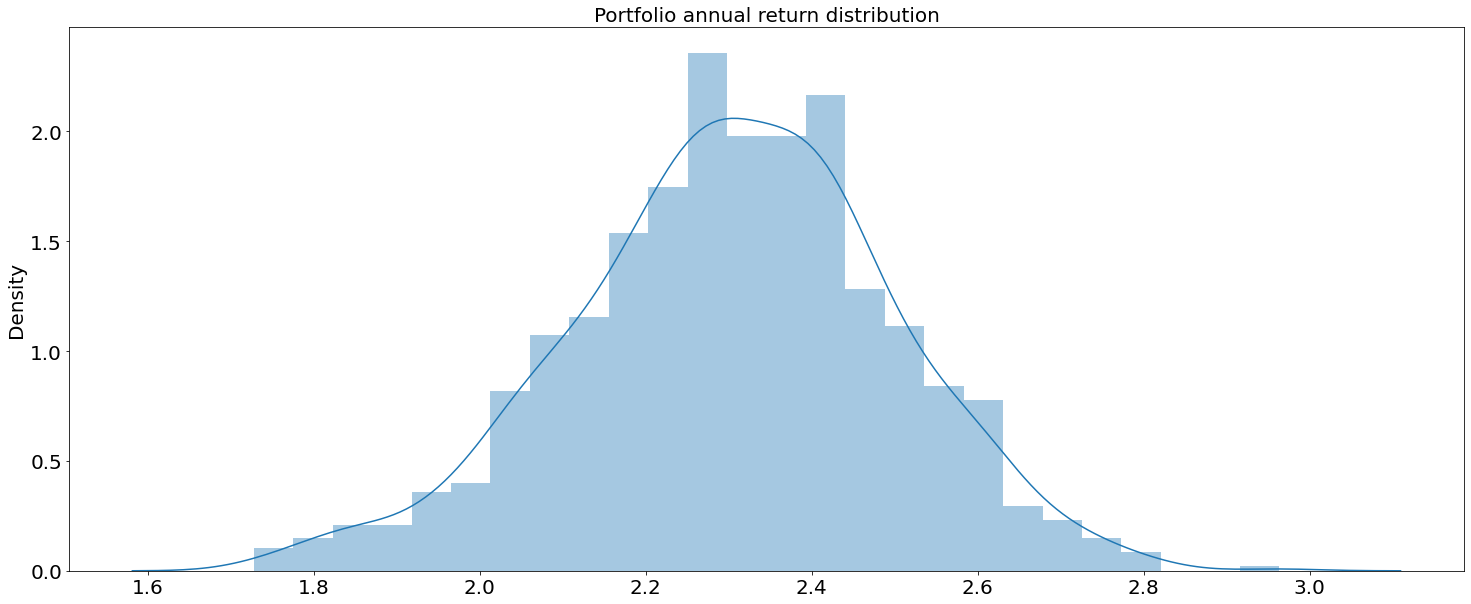

In [95]:
#ROI,Sharpe ratio and distribution plot for a portfolio of 10,000 loans without model (baseline)
portfolio_return(results,10000)

Average return for portfolio: 4.54
Standard Deviation: 0.14 
Sharpe Ratio: 21.71


[4.54, 0.14, 21.71]

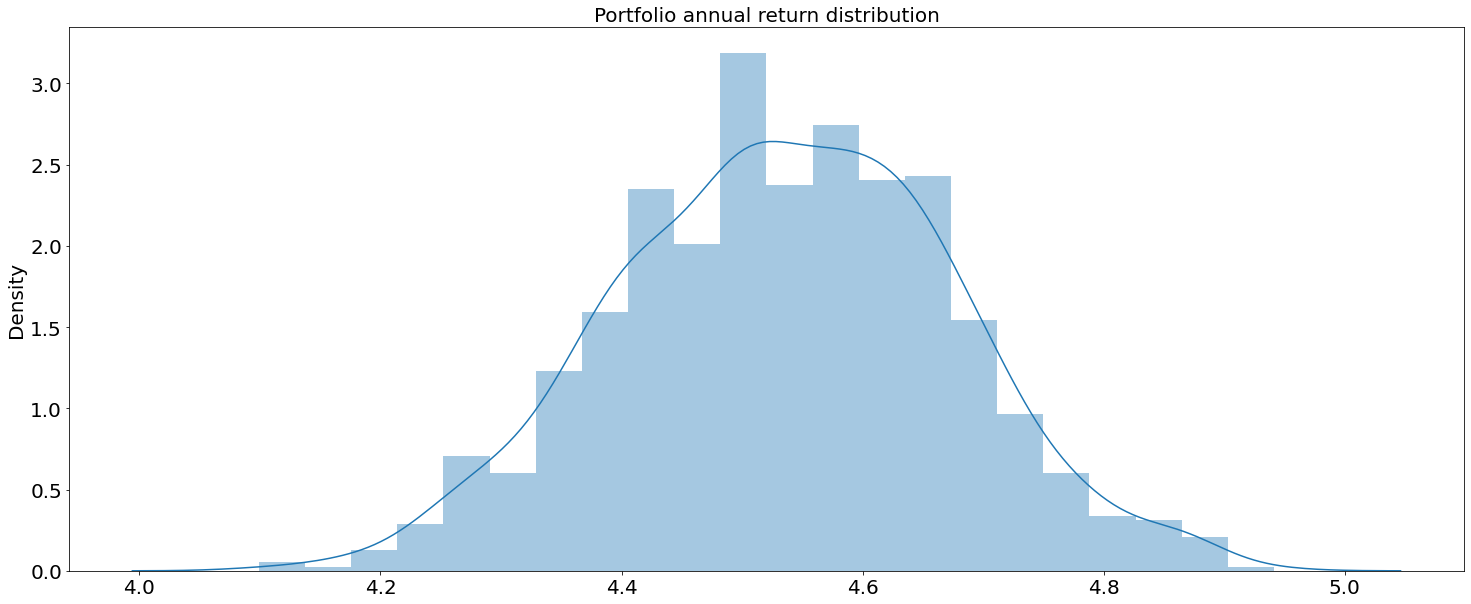

In [96]:
#ROI,Sharpe ratio and distribution plot for a portfolio of 10,000 loans with model
portfolio_return(results_clean,10000)

**Conclusion**: From the sharpe ratio and portfolio annual return distribution, the average annual return and sharpe ratio from randomly selecting 10,000 loans to invest are around 2.3% and 4.5% respectively. When using the classification model to predict default of loans and selecting 10,000 loans which are predicted not to default, the average annual return and sharpe ratio are around 4.5% and 22 respectively. Thus, investors can significantly increase their risk adjusted annual returns (by around 5 times) by using the model to select the P2P loans to invest.